## Team Members:

### Zafar Ahamad ()
### Ubaid Ullah Hafeez (111195374)


## Part 1
    Our Scoring function, f takes data about a property as input and returns a pair of non_geographical score and geographical score:
    f(data) = (non_geographical score, geographical score)

### Non-Geographical Score

#### Some Interesting Facts About Real-Estate :
       Our Scoring function is based on some of the observations about houses being sold in last few years by some real-estate researchers which are as follows :
- Buyers generally prefer centrally air-conditioned homes and are willing to pay more
- Houses sold in last three years have 2-3 average number of bathrooms
- Houses sold in last three years have 3-4 average number of bedrooms
- Most of the Houses sold have a garage which has space for 2 cars
- In California, heat pumps are perferred heating system because of energy efficiency and providing necesssary amount of heating when needed
- Most of the buyers prefer a single story or a double story house, not more than that. In addition to that people prefer to have an attic or basement for extra space and storage
- Other than bedrooms, people prefer to have some extra rooms like laundry room, a dine-in kitchen, some common sitting room etc and are willing to pay more for these
- Most preferred unit count is one
- People prefer to have a patio and storage room and are in most cases willing to pay more for these.

#### Some Deductions:
    Following are some considerations based on our own sniff test after looking at the data:
- A newer house is more desirable to an old one, unless the old house is an antique one and is well maintained and well kept
- Areas where tax is high are those with good neighborhoods and have really good facilities for residents, so the houses with higher tax / sqft of area should be more desirable

#### Scoring Function
    Keeping the above things in mind, we picked a subset of 15 columns from the given data and scored each of them indivivually such that score reflects the above mentioned points. General technique we used is to find the best in the each column and assign decreasing score from there to all the other values based on how far apart these are from the best. After assigning scores, normaliz each of the column individually. Now, to find the accumalated score, we just sum the score of all the columns. Following is the list of columns that we used:

- **airconditioningtypeid**
- **bathroomcnt**
- **bedroomcnt**
- **buildingqualitytypeid**
- **garagetotalsqft**
- **heatingorsystemtypeid **
- **numberofstories**
- **propertylandusetypeid**
- **roomcnt**
- **unitcnt**
- **yardbuildingsqft17**
- **yardbuildingsqft26**
- **yearbuilt**
- **landtaxvaluedollarcnt**

#### How good is the scoring function
    We think our scoring function is decent based on the two observations. First one being the difference in the scores of houses on the extreme values being higher as compared to differences in the scores close to mean being lower. Second observation is that the distribution looks close to normal distribution which suggests that it scores houses in a way that we are used to see, which decent ennough reasoning to say that this scoring function worked just fine.
    
### Geographical Score

#### Finding Correct Zip-Codes (Zafar, you might want to edit this)
    We used a data-set that maps california lattitudes and longitudes to zipcodes to find the correct zip-codes about the datapoints in given dataset. Now we created a data-set that compared the price of the houses similar to the best house given by the above non geographical score across all the zipcodes and based on this, we assigned score to to each of the zipcodes such that the zipcode where a similar house is cheaper is given a lower score as compared to the expensive one.


/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
*********** least Desirable House ***********
         parcelid  airconditioningtypeid  architecturalstyletypeid  \
2352118  13987714                    NaN                       NaN   

         basementsqft  bathroomcnt  bedroomcnt  buildingclasstypeid  \
2352118           NaN          0.0         0.0                  NaN   

         buildingqualitytypeid  calculatedbathnbr  decktypeid  \
2352118                    NaN                NaN         NaN   

                ...           numberofstories  fireplaceflag  \
2352118         ...                       2.0            NaN   

         structuretaxvaluedollarcnt  taxvaluedollarcnt  assessmentyear  \
2352118                    217625.0           382633.0          2016.0   

         landtaxvaluedollarcnt  taxamount  taxdelinquencyflag  \
2352118               165008.0    5489.84                 NaN   

         taxdelinquencyyear  censustractandblock  
2352118                 NaN         6.059088e+13  

[1 rows x 58 

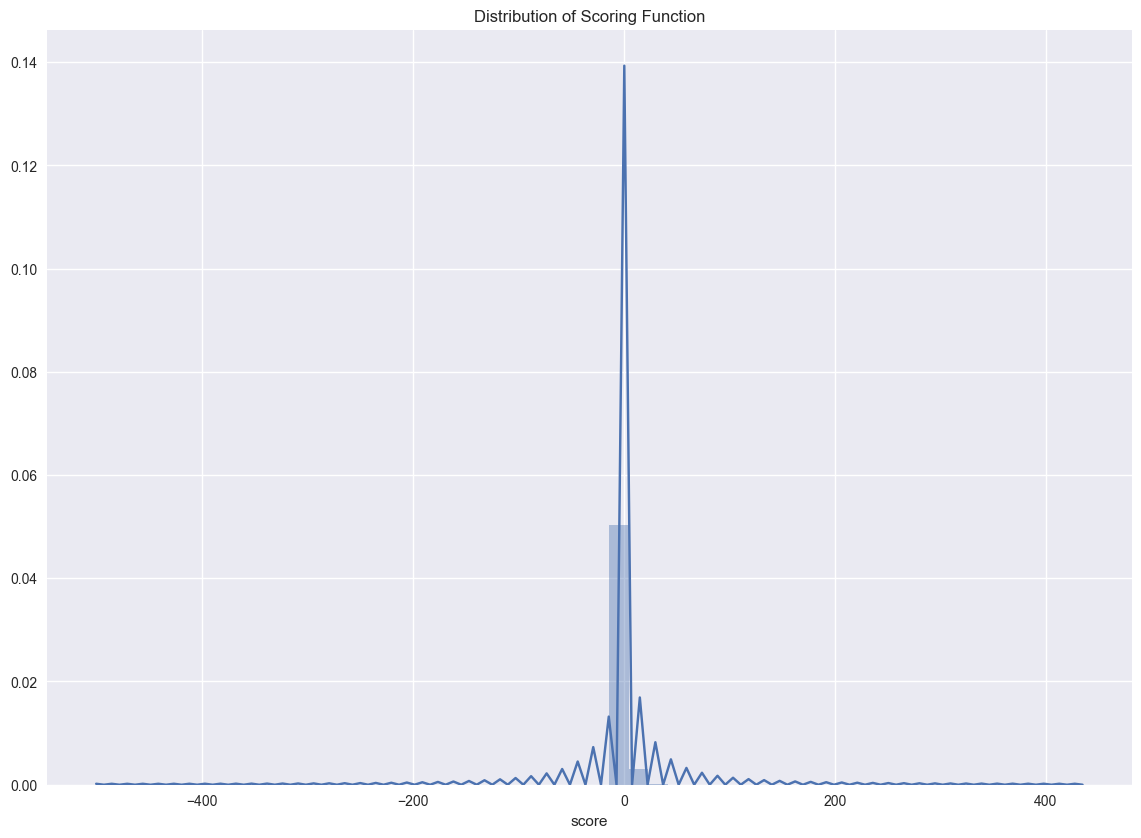

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from copy import deepcopy

'''
A Function to get Stats about a columns, 
@params, df = dataframe, col = column_name
'''
def get_details(df, col):
	print(col)
	tmp = df.loc[:, col]
	uni = tmp.unique()
	uni.sort()
	print('Unique Entries : ', uni)
	# print(type(tmp.unique()))
	print('Total Number of Unique Entries', len(tmp.unique()))
	print('Total Number of NaNs/Missing Values: ', tmp.isnull().sum())
	# print(int(tmp.mean()))
	print('Mean : ', tmp.mean())
	print('Max : ', tmp.max())
	print('Min : ', tmp.min())


# Array to hold all the columns that are part of desirability scoring function
desirable_features = ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'garagetotalsqft', 'heatingorsystemtypeid', 
'numberofstories', 'propertylandusetypeid', 'roomcnt', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'landtaxvaluedollarcnt']

# Reading Data
properties_file = 'properties_2017.csv'
df = pd.read_csv(properties_file)
print(df.shape)

# Filling the Dataframe with scores instead of the values for all the features that are part of desirability function

tmp = df.loc[:,'airconditioningtypeid']
tmp.fillna(6, inplace=True)
df['airconditioningtypeid'].replace([1, 4], 1, inplace=True)
df['airconditioningtypeid'].replace([2, 3, 6, 7, 8, 9, 10, 11, 12, 13], 0, inplace=True)
df['airconditioningtypeid'].replace([5], -1, inplace=True)


tmp = df.loc[:,'bathroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = df.loc[:,'bathroomcnt'] - 2.5
df.loc[:,'bathroomcnt'] = tmp
# df.loc[(df['bathroomcnt'] > 2.5), 'bathroomcnt'] = -2.5
# df.loc[(df['bathroomcnt'] >= 0), 'bathroomcnt'] = 1


tmp = df.loc[:,'bedroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = (df.loc[:,'bedroomcnt'] - 3)
df.loc[:,'bedroomcnt'] = tmp
# df.loc[(df["bedroomcnt"] >= 4), 'bedroomcnt'] = -4
# tmp = (df.loc[:,'bedroomcnt']).abs()*(-1)
# tmp = tmp + 1
# df.loc[:,'bedroomcnt'] = tmp

tmp = df.loc[:,'buildingqualitytypeid']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp.abs()*(-1)
tmp = tmp + 2
df.loc[:,'buildingqualitytypeid'] = tmp

tmp = df.loc[:,'garagetotalsqft']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp - 484
# tmp = tmp.abs()*(-1)
# tmp = tmp + 1
df.loc[:,'garagetotalsqft'] = tmp
# df.loc[(df['garagetotalsqft'] >= -43), 'garagetotalsqft'] = 1


tmp = df.loc[:,'heatingorsystemtypeid']
tmp.fillna(int(tmp.mean()), inplace=True)
df.loc[(df['heatingorsystemtypeid'] != 11), 'heatingorsystemtypeid'] = 0
df.loc[(df['heatingorsystemtypeid'] == 11), 'heatingorsystemtypeid'] = 1

tmp = df.loc[:,'numberofstories']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1) + 2
df.loc[:,'numberofstories'] = tmp


tmp = df.loc[:,'propertylandusetypeid']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1) + 32
df.loc[:,'propertylandusetypeid'] = tmp

tmp = df.loc[:,'bedroomcnt']
tmp.fillna(tmp.mean(), inplace=True)
tmp1 = df.loc[:,'roomcnt'] - tmp
tmp1.fillna(0, inplace=True)
tmp1 = (tmp1 - 5).abs()*(-1) + 1
df.loc[:,'roomcnt'] = tmp1
df.loc[(df['roomcnt'] >= -1), 'roomcnt'] = 1
df.loc[(df['roomcnt'] >= -2) & (df['roomcnt'] < -1), 'roomcnt'] = 0.5

tmp = df.loc[:,'unitcnt']
tmp.fillna(int(tmp.mean()), inplace=True)
tmp = tmp.abs()*(-1)
tmp = tmp + 2
df.loc[:,'unitcnt'] = tmp

tmp = df.loc[:,'yardbuildingsqft17']
tmp.fillna(0, inplace=True)
df.loc[(df["yardbuildingsqft17"] > 0), 'yardbuildingsqft17'] = 1

tmp = df.loc[:,'yardbuildingsqft26']
tmp.fillna(0, inplace=True)
df.loc[(df["yardbuildingsqft26"] > 0), 'yardbuildingsqft26'] = 1

tmp = df.loc[:,'yearbuilt']
tmp.fillna(tmp.mean(), inplace=True)
tmp = tmp - 2015
df.loc[:,'yearbuilt'] = tmp


tmp = df.loc[:,'landtaxvaluedollarcnt']
tmp1 = df.loc[:,'lotsizesquarefeet']
tmp = tmp / tmp1
df.loc[:,'landtaxvaluedollarcnt'] = tmp


# picking the desirable features columns from the complete dataset
data = df.loc[:, desirable_features]

# Normalizing individual scores
data = (data - data.mean())/(data.std(ddof=0))

# Accumulating scores
scr = data.sum(axis=1)

# Findinge Distribution of Scores
temp = scr.values.tolist()
sns.plt.figure(figsize=(14, 10), dpi= 100)
sns.plt.xlabel('score')
plt.title('Distribution of Scoring Function')
sns.distplot(temp);

# Mapping Scores with Parcel IDs
data['score'] = scr
ids = df.loc[:, 'parcelid']
score = data.loc[:, 'score']
scores = pd.concat([ids, score], axis=1)
scores = scores.sort_values(by='score')

# Finding the most desirable and least desirable houses
lowest = scores.head(1)
highest = scores.tail(1)
lowest_pid = lowest.loc[:, 'parcelid'].values.tolist()
highest_pid = highest.loc[:, 'parcelid'].values.tolist()

df = pd.read_csv(properties_file)

print('*********** least Desirable House ***********')
for pid in lowest_pid:
	print(df.loc[(df['parcelid'] == pid), :])


print('*********** most Desirable House ***********')
for pid in highest_pid:
	print(df.loc[(df['parcelid'] == pid), :])

# Ploting Distribution of Scores

# sns.plt.gca().set_aspect('equal')
sns.plt.show()




## Part 2
    Our scoring function returns a pair i.e. (Non-Geo_Score, Geo_Score). We represented each property with this ordered pair and our distance metric is just the eucleidian distance of these ordered pairs of each pair of properties. We will discuss about the goodness of this metric in **Part 3** when we discuss clustering.  

## Part 3

### How Many Clusters?
    There is an algorithm for clustering called DBSCAN which don't take the number of clusters as an input parameter, instead it takes another parameter called eps which is related to the distances among the points that we want to cluster. We read upon this and found that if we find the distance of each point to its 3rd neighbor and plot it. The point where we find the 'knee' in the plot is a suitable value for eps for DBSCAN.
    So, 'knee' of the said graph appears at about 0.6 so we used this as eps. After that, we ran DBSCAN with eps=0.6 and DBSCAN clustered the points into two clusters. This way, we found out that classifying the above data into 2 clusters is a good idea.

### Clustering
    DBSCAN don't cluster outliers and researchers say its not good at prediction. So, we clustered the data using KMeans into two clusters

### Comments About the Distance Metric
    - A good distance metric should have just one 'knee' in the nearest neighbors plot and it should be towards the end (it is clear in the plot below).
    - Another comment about the distance metric is that it should be easy to calculate which ours is.
    - When you cluster using a distance metric, if you see clear clusters and few outliers. This gives us the sense that the metric we used works well with the clustering technique. In our case, clusters are not very clear, but outliers are very few. So, our distance metric is not very good, but its not bad either.


## Part 5 
    We tried a bunch of things which are as follows (Zafar you may want to edit this):
- Clustering based on Desirability and Regression on Features
- Predicting logerror just using the desirablility
- Regression on Desirability
- Regression Using some Selected Features
- XGBoost on Features
- Taking care of Outliers while training
- Clustering based on Desirability and regression using XGBoost on selected features of properties already given to us (This worked best)

### Best Model
    Our best model was based on Clustering and using multiple predictors based on XGBoost. What we did is as follows:
- Created clusters using desirability scores of training data using KMeans clustering and to decide on the parameters, we used the same technique as explained in part 3
- For each cluster train a predictor based on XGBoost using all the points that lie in that cluster. This predictor was based on all the actual features of the data not just desirability scores
- Predict the clusters of all data in the sample_submission file on Zillow using KMeans predictor
- For each data point, use the predictor of the predicted cluster to predict the log_error

### Why this Model is Best?
    We think this model works best because our desirability score is based mostly on the features provided already in the data-set and clustering based on desirability, clusters the similar houses together. So, if we use the desirability of a house to find the houses that are similar and then use the regressor that is trained only based on similar houses is more likely to predict a better log-error as compared to a regressor that is trained using all the houses. The reasone behind this is that the predictor used by zillow is most likely dealing the houses with similar desirability in a similar way.

### Interesting Findings: (Zafar you may want to edit this)
    We have a strong feeling that if we refine our desirabiity score a bit more and get more fine grain clustering and spend some more time exploring the best parameters for the tools we used in this assignment, its likely that we can get a score in top 10 or atleast top 100, but I think that's out of the scope of this assignment considering the time alloted.
    
### Yes Professor, You were Right!
If we don't use clustering based on desirability and use only one XGBoost regressor to predict logerrors for all the properties accuracy of prediction is less, which means since clustering based on desirability makes us more faimilar with the data. It in a sense, enables us to guess logerrors for rest of data in a more educated manner.


